In [97]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.manifold import TSNE

In [98]:
# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [99]:
RESULTS_FILE = os.path.join(INPUT_FOLDER, "simulation_results.csv")
df = pd.read_csv(RESULTS_FILE)
df.head(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
0,0.001,0.001,0.998,450000.0,700000.0,3.0,0.090909,0.000313,0.714132
1,0.001,0.001,0.998,450000.0,700000.0,3.0,0.181818,0.010239,2.507203
2,0.001,0.001,0.998,450000.0,700000.0,3.0,0.272727,0.645766,18.451377
3,0.001,0.001,0.998,450000.0,700000.0,3.0,0.363636,0.294084,11.326070
4,0.001,0.001,0.998,450000.0,700000.0,3.0,0.454545,0.831464,19.566638


In [100]:
print('Data rows:', df.shape[0])

Data rows: 897255


In [101]:
# Observing data tail
df.tail(5)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
897250,0.0091,0.0037,0.9872,480000.0,980000.0,3.0,0.000000,0.157615,8.449645
897251,0.0082,0.0037,0.9881,500000.0,870000.0,3.0,0.454545,0.067897,5.320042
897252,0.0082,0.0046,0.9872,510000.0,1030000.0,3.0,0.636364,0.061325,5.334185
897253,0.0082,0.0037,0.9881,580000.0,1170000.0,3.0,0.454545,0.049253,4.881684
897254,0.0091,0.0064,0.9845,460000.0,900000.0,3.0,0.818182,3.981980,59.276283


In [102]:
# Observing a sample
SAMPLE_SIZE = 5
start = np.random.randint(0, len(df) - SAMPLE_SIZE + 1)
sample_df = df.iloc[start : start + SAMPLE_SIZE]

sample_df.head(SAMPLE_SIZE)

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
783508,0.0091,0.0028,0.9881,490000.0,800000.0,3.0,0.363636,7.622797,94.821230
783509,0.0082,0.0064,0.9854,450000.0,780000.0,3.0,0.000000,9051.066390,0.666735
783510,0.0091,0.0082,0.9827,500000.0,950000.0,3.0,0.272727,11699.950000,0.581710
783511,0.0091,0.0064,0.9845,480000.0,1060000.0,3.0,0.454545,9204.539050,0.018526
783512,0.0082,0.0082,0.9836,520000.0,860000.0,3.0,0.818182,11796.467800,0.335012


In [103]:
df.describe()

,feedNH3,feedH2S,feedH20,QN1,QN2,QC,SF,H2S_ppm,NH3_ppm
count,897254.000000,897255.000000,897255.000000,897255.000000,8.972550e+05,897255.0,897255.000000,8.972550e+05,8.972550e+05
mean,0.005049,0.005050,0.989901,524999.860686,9.499940e+05,3.0,0.454533,4.364661e+03,8.060725e+01
std,0.002585,0.002585,0.003656,46098.094915,1.471950e+05,0.0,0.287474,1.372127e+04,5.628852e+03
min,0.001000,0.001000,0.981800,450000.000000,7.000000e+05,3.0,0.000000,1.634596e-30,3.719056e-32
25%,0.002800,0.002800,0.987200,480000.000000,8.200000e+05,3.0,0.181818,4.148268e-01,2.394929e-03
50%,0.004600,0.005500,0.989900,530000.000000,9.500000e+05,3.0,0.454545,1.660825e+03,6.077546e+00
75%,0.007300,0.007300,0.992600,570000.000000,1.080000e+06,3.0,0.727273,7.546250e+03,2.247266e+01
max,0.009100,0.009100,0.998000,600000.000000,1.200000e+06,3.0,0.909091,1.000000e+06,1.000000e+06


In [104]:
# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

# Check for zero values
zero_check = (df == 0).sum()
print("\nZero values per column:\n", zero_check)


NaN values per column:
 feedNH3    1
feedH2S    0
feedH20    0
QN1        0
QN2        0
QC         0
SF         0
H2S_ppm    0
NH3_ppm    0
dtype: int64

Zero values per column:
 feedNH3        0
feedH2S        0
feedH20        0
QN1            0
QN2            0
QC             0
SF         81564
H2S_ppm        0
NH3_ppm        0
dtype: int64


In [105]:
# Filter rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print("Rows with NaN values:\n", nan_rows)


Rows with NaN values:
         feedNH3  feedH2S  feedH20       QN1       QN2   QC        SF  \
152531      NaN   0.0019   0.9962  510000.0  730000.0  3.0  0.181818   

         H2S_ppm    NH3_ppm  
152531  1.482682  29.982455  


In [106]:
# Drop rows with any NaN values
df = df.dropna()

# Optionally, reset the index if needed
df = df.reset_index(drop=True)

# Check for NaN values
nan_check = df.isna().sum()
print("NaN values per column:\n", nan_check)

NaN values per column:
 feedNH3    0
feedH2S    0
feedH20    0
QN1        0
QN2        0
QC         0
SF         0
H2S_ppm    0
NH3_ppm    0
dtype: int64


In [107]:
# Drop columns
df = df.drop(columns=['QC', 'feedH20'])
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_ppm,NH3_ppm
0,0.001,0.001,450000.0,700000.0,0.090909,0.000313,0.714132
1,0.001,0.001,450000.0,700000.0,0.181818,0.010239,2.507203
2,0.001,0.001,450000.0,700000.0,0.272727,0.645766,18.451377
3,0.001,0.001,450000.0,700000.0,0.363636,0.294084,11.326070
4,0.001,0.001,450000.0,700000.0,0.454545,0.831464,19.566638


In [108]:
# Applying the rule to transform the last two columns into binary values
df['H2S_binary'] = df['H2S_ppm'] <= 0.2
df['NH3_binary'] = df['NH3_ppm'] <= 15
df['H2S_binary'] = df['H2S_binary'].astype(int)
df['NH3_binary'] = df['NH3_binary'].astype(int)
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_ppm,NH3_ppm,H2S_binary,NH3_binary
0,0.001,0.001,450000.0,700000.0,0.090909,0.000313,0.714132,1,1
1,0.001,0.001,450000.0,700000.0,0.181818,0.010239,2.507203,1,1
2,0.001,0.001,450000.0,700000.0,0.272727,0.645766,18.451377,0,0
3,0.001,0.001,450000.0,700000.0,0.363636,0.294084,11.326070,0,1
4,0.001,0.001,450000.0,700000.0,0.454545,0.831464,19.566638,0,0


In [109]:
# Drop columns
df = df.drop(columns=['H2S_ppm', 'NH3_ppm'])
df.head()

,feedNH3,feedH2S,QN1,QN2,SF,H2S_binary,NH3_binary
0,0.001,0.001,450000.0,700000.0,0.090909,1,1
1,0.001,0.001,450000.0,700000.0,0.181818,1,1
2,0.001,0.001,450000.0,700000.0,0.272727,0,0
3,0.001,0.001,450000.0,700000.0,0.363636,0,1
4,0.001,0.001,450000.0,700000.0,0.454545,0,0


In [110]:
# Separate features and labels from original df first
df2_x = df.iloc[:, :-2]  # All columns except last two
df2_bin_y = df.iloc[:, -2:]  # Only last two columns

scaler2_x = PowerTransformer()

df2_scaled_x = pd.DataFrame(scaler2_x.fit_transform(df2_x), 
                            columns=df2_x.columns, 
                            index=df2_x.index)

df2_scaled = df2_scaled_x.join(df2_bin_y)
print("Scaled DataFrames created successfully!")

Scaled DataFrames created successfully!


In [111]:
# Export the scaled dataframe using joblib
joblib.dump(df2_scaled_x, os.path.join(INPUT_FOLDER, 'df2_scaled_x.joblib'))
joblib.dump(df2_bin_y, os.path.join(INPUT_FOLDER, 'df2_bin_y.joblib'))

# Export the scalers using joblib
joblib.dump(scaler_x, os.path.join(INPUT_FOLDER, 'scaler2_x.joblib'))

print("Data and scalers exported successfully to the input files folder!")

Data and scalers exported successfully to the input files folder!


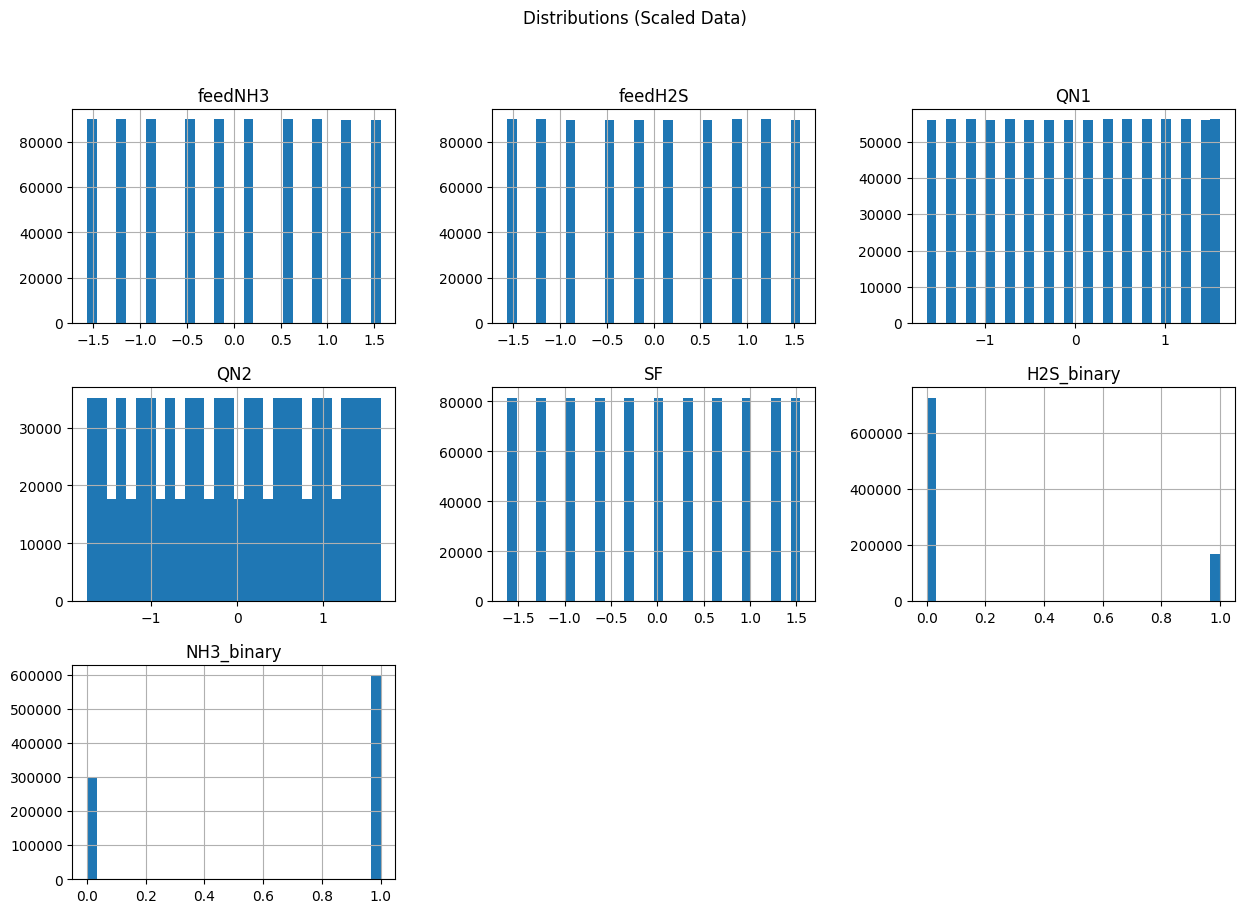

In [112]:
# Data Distribution and Descriptive Statistics
# Histograms for each feature in df_scaled_x
df_scaled.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions (Scaled Data)")
plt.show()

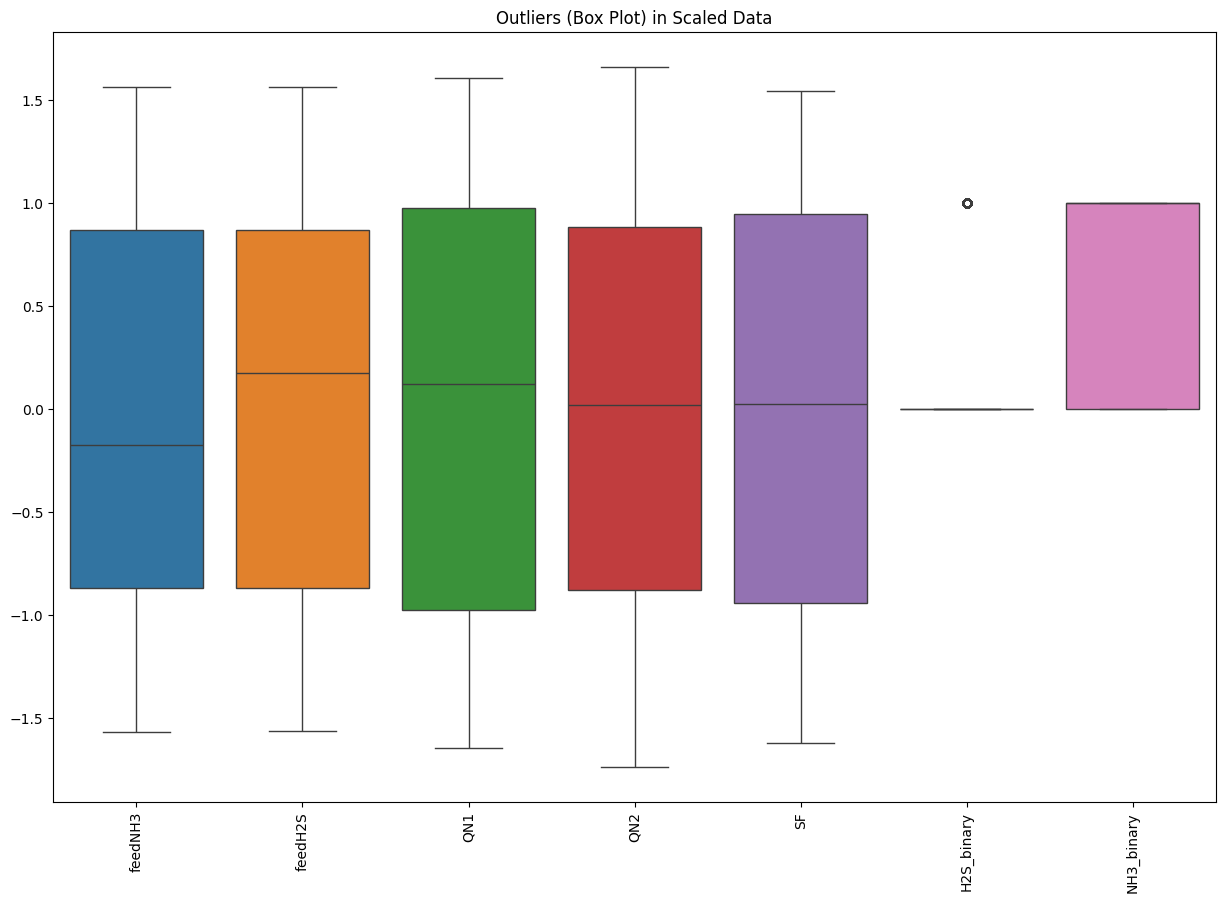

In [113]:
# Box plots to check for outliers in df_scaled_x
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=90)
plt.title("Outliers (Box Plot) in Scaled Data")
plt.show()

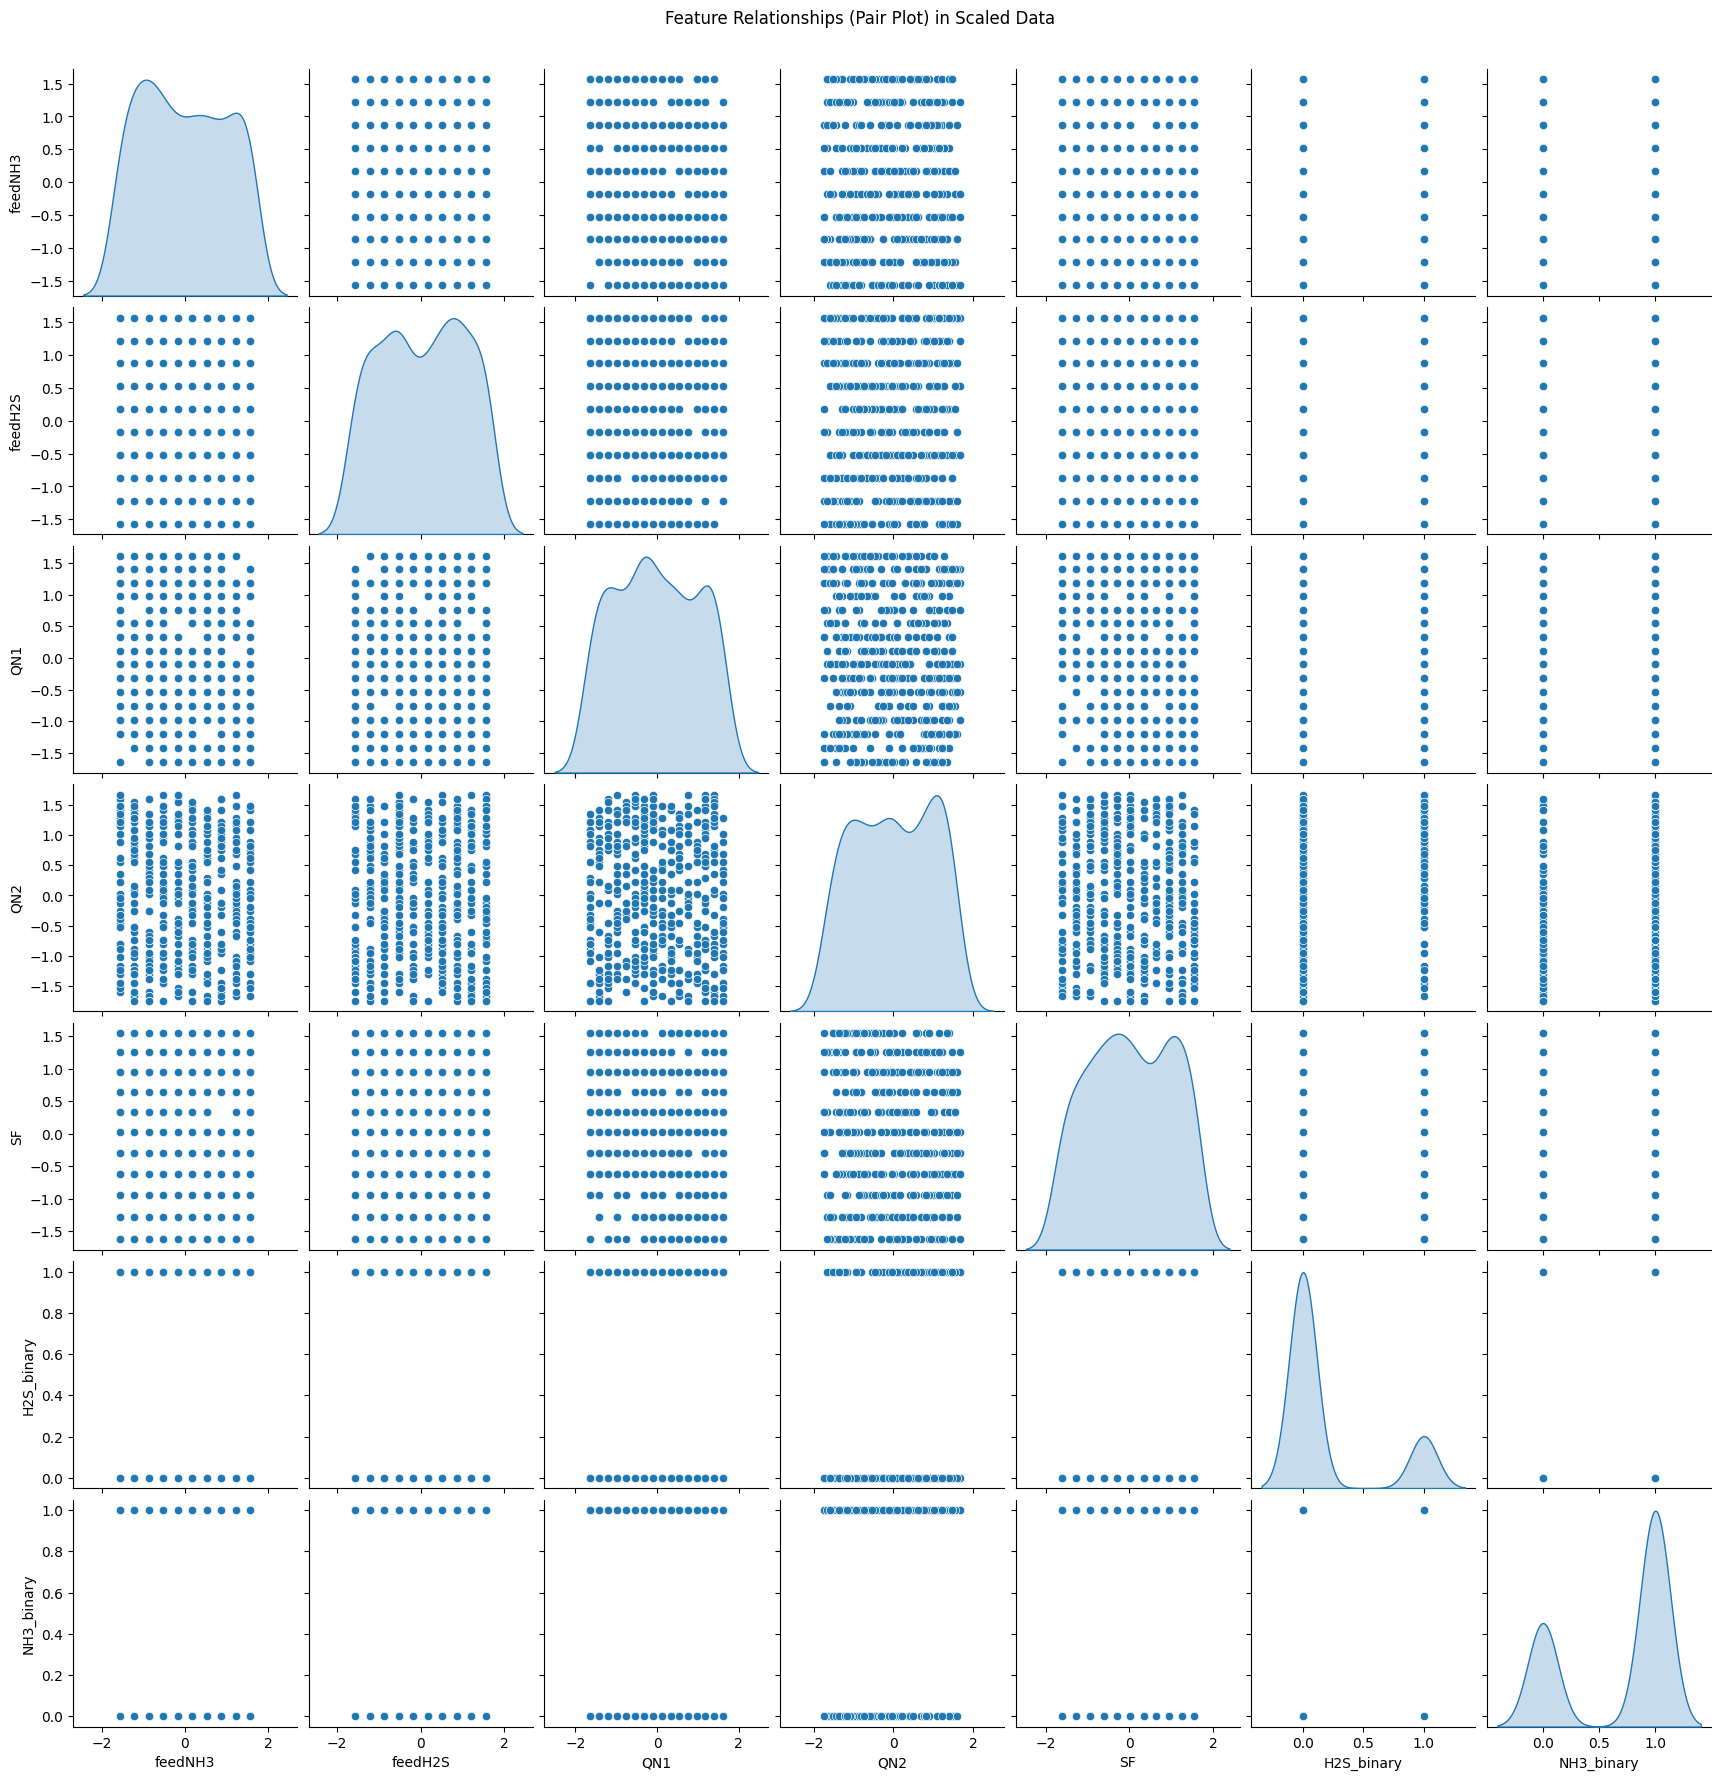

In [114]:
# Pair Plot (if data size is manageable)
sns.pairplot(df_scaled.sample(n=min(500, len(df_scaled))), diag_kind='kde')
plt.suptitle("Feature Relationships (Pair Plot) in Scaled Data", y=1.02)
plt.show()

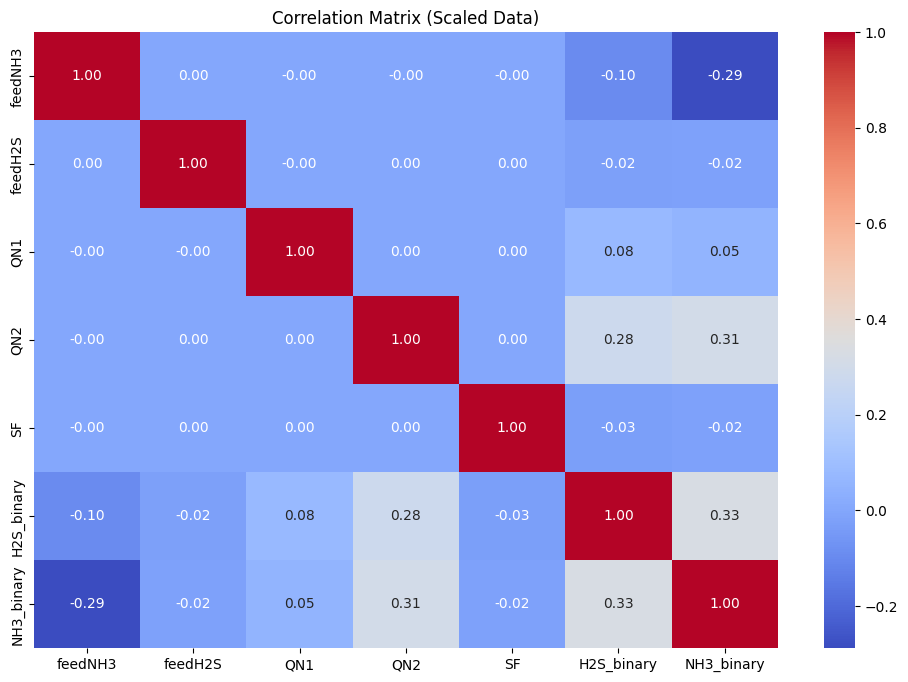

In [115]:
# Correlation Analysis
# Heatmap for Correlation Matrix in df_scaled_x
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Scaled Data)")
plt.show()

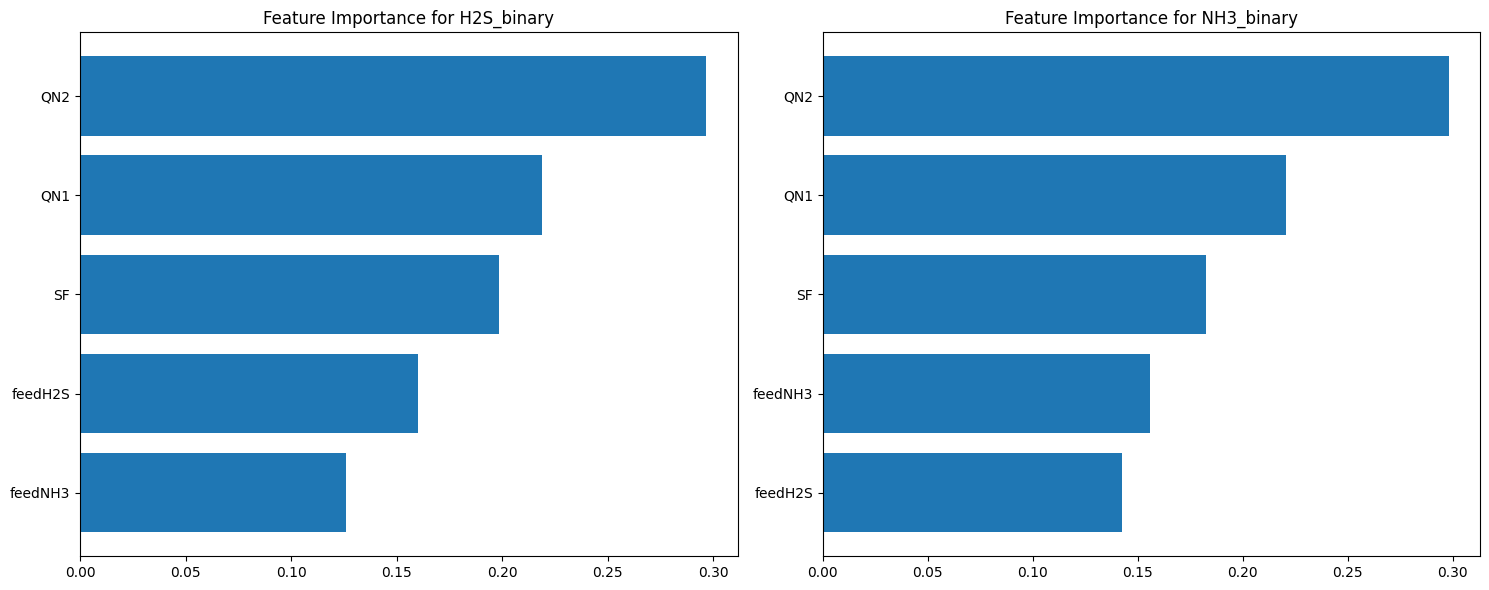


feedNH3:
H2S_binary: 0.1259
NH3_binary: 0.1560

feedH2S:
H2S_binary: 0.1602
NH3_binary: 0.1426

QN1:
H2S_binary: 0.2188
NH3_binary: 0.2209

QN2:
H2S_binary: 0.2966
NH3_binary: 0.2981

SF:
H2S_binary: 0.1986
NH3_binary: 0.1825


In [116]:
# Create and fit model
multi_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_model.fit(df_scaled_x, df_scaled_y)

# Create plot
plt.figure(figsize=(15, 6))

# Plot for each target
for i, (estimator, target_name) in enumerate(zip(multi_model.estimators_, df_scaled_y.columns)):
    plt.subplot(1, 2, i+1)
    sorted_idx = np.argsort(estimator.feature_importances_)
    plt.barh(df_scaled_x.columns[sorted_idx], estimator.feature_importances_[sorted_idx])
    plt.title(f"Feature Importance for {target_name}")

plt.tight_layout()
plt.show()

# Print values if needed
for feature in df_scaled_x.columns:
    print(f"\n{feature}:")
    for i, target_name in enumerate(df_scaled_y.columns):
        print(f"{target_name}: {multi_model.estimators_[i].feature_importances_[df_scaled_x.columns.get_loc(feature)]:.4f}")

In [117]:
# # Visualizing High-Dimensional Data with t-SNE
# # Using t-SNE to reduce features to 2 dimensions for visualization
# tsne = TSNE(n_components=2, random_state=42)
# x_tsne = tsne.fit_transform(df_scaled_x)

# # Plot t-SNE result, coloring points by the mean of the target values in df_scaled_y
# plt.figure(figsize=(10, 8))
# plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=df_scaled_y.mean(axis=1), cmap="viridis", alpha=0.7)
# plt.colorbar(label='Mean Target Value (Scaled Data)')
# plt.title("t-SNE Visualization of Scaled Features (Colored by Mean Target Value)")
# plt.show()